In [ ]:
#研究区概况
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import pandas as pd
from osgeo import gdal
from matplotlib import cm
import os
from tqdm import trange
import tqdm

def mapping(language='ch'):
    def init_background(mapn, axn,dem_path=None,shape_path=None):
        china_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国全境"
        world_path = r"E:\范围shp文件\世界地图\世界国家"
        line_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国边界线"
        province_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国省份分界线"
        mapn.readshapefile(world_path,
                           name='world',
                           drawbounds=False,
                           default_encoding='gbk')
        df = pd.DataFrame(mapn.world_info)
        not_china_index = np.array(df[df["NAME"] != "CHINA"].index)
        del df
        p1 = PatchCollection(
            [
                Polygon(i)
                for i in np.array(mapn.world, dtype=object)[not_china_index]
            ],
            edgecolors='black',
            facecolors='lightgray',
            linewidths=0.2,
        )
        axn.add_collection(p1)
        del p1
        mapn.readshapefile(china_path, name='china')

        p2 = PatchCollection(
            [Polygon(i) for i in np.array(mapn.china, dtype=object)],
            edgecolors='black',
            facecolors='lightgray',
            linewidth=0.8)
        axn.add_collection(p2)
        del p2
        mapn.readshapefile(line_path, name='china_line', linewidth=0.8)

        #加载dem
        if dem_path is not None:
            ds=gdal.Open(dem_path)
            data = ds.ReadAsArray()
            (xmin, xl, _, ymax, _, _) = ds.GetGeoTransform()
            width = data.shape[1]
            height = data.shape[0]
            ndv = ds.GetRasterBand(1).GetNoDataValue()
            data = np.ma.masked_where(data == ndv, data)
            ymin = ymax - height * xl
            xmax = xmin + width * xl
            x = np.linspace(xmin, xmax, width)
            y = np.linspace(ymin, ymax, height)[::-1]
            xx, yy = np.meshgrid(x, y)
            ticks = [-1000,0, 200, 500, 1000,1500, 2000, 3000, 4000, 5000, 6000,9000]
            colors=plt.cm.get_cmap("gist_earth")(np.linspace(0.5, 1,11))
            cntr = mapn.contourf(xx, yy, data,levels=ticks,colors=colors)
            colorbar = mapn.colorbar(cntr, size='3.5%', ticks=ticks[1:-1])
            colorbar.ax.tick_params(labelsize=14)
        if shape_path is not None:
            df = pd.read_csv(shape_path)
            chazhi_lon = np.array(df[df["类型"] != "插值"]["longitude"])
            chazhi_lat=np.array(df[df["类型"] != "插值"]["latitude"])
            yanzheng_lon = np.array(df[df["类型"] != "验证"]["longitude"])
            yanzheng_lat = np.array(df[df["类型"] != "验证"]["latitude"])
            del df
            chazhi=mapn.scatter(chazhi_lon, chazhi_lat,c="red",s=2)
            yanzheng = mapn.scatter(yanzheng_lon, yanzheng_lat, c="blue",s=2)
            axn.legend(handles=[chazhi, yanzheng],
                       loc='lower left',
                       labels=[
                           "Monitoring Station:Training Set",
                           "Monitoring Station:Validation Set"
                       ],
                       fontsize=15)
        mapn.readshapefile(
            province_path,
            name='province',
            linewidth=0.2,
        )

    # 用来正常显示中文
    plt.rcParams['font.sans-serif'] = ['SimHei']
    # 用来正常显示负号
    plt.rcParams['axes.unicode_minus'] = False
    # print(title_keys)
    # sfigs = fig.subfigures(5, 2)

    fig = plt.figure(figsize=(12, 9), dpi=200,facecolor='white')

    left, bottom, width, height = 0.025, 0.05, 0.95, 0.95
    # sfig = sfigs[i][j]
    ax1 = fig.add_axes([left, bottom, width, height])
    map1 = Basemap(llcrnrlon=73,
                    llcrnrlat=18,
                    urcrnrlon=136,
                    urcrnrlat=54,
                    ax=ax1)
    dem_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\dem_1km_Clip.tif"
    shape_path = r"E:\研究生毕业论文\实验部分\气象站点数据\气象站点数据_经纬度_使用.txt"
    init_background(map1, ax1, dem_path, shape_path)

    map1.drawparallels(np.linspace(20, 50, 7),
                        labels=[1, 0, 0, 0],
                        linewidth=0,
                        fontsize=14)
    map1.drawmeridians(np.linspace(75, 135, 7),
                       labels=[0, 0, 0, 1],
                       linewidth=0,
                       fontsize=14)
    ax2 = fig.add_axes([0.775, 0.15, 0.15, 0.3])
    map2 = Basemap(llcrnrlon=106,
                    llcrnrlat=2,
                    urcrnrlon=124,
                    urcrnrlat=23,
                    ax=ax2)
    if language == 'ch':
        ax2.text(0.98,
                    0.02,
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    s=f"中国南海",
                    transform=ax2.transAxes,
                    fontsize=15)
        # fig.text(0.966, 0.875, '高度表（米）', fontsize=8)
    elif language == 'en':
        ax2.text(
            0.98,
            0.02,
            horizontalalignment='right',
            verticalalignment='bottom',
            s=f"South China Sea",
            transform=ax2.transAxes,
            fontsize=15,
        )
        fig.text(0.93, 0.88, 'Elevation(m)', fontsize=12)
    init_background(map2, ax2)
    plt.show()
mapping('en')

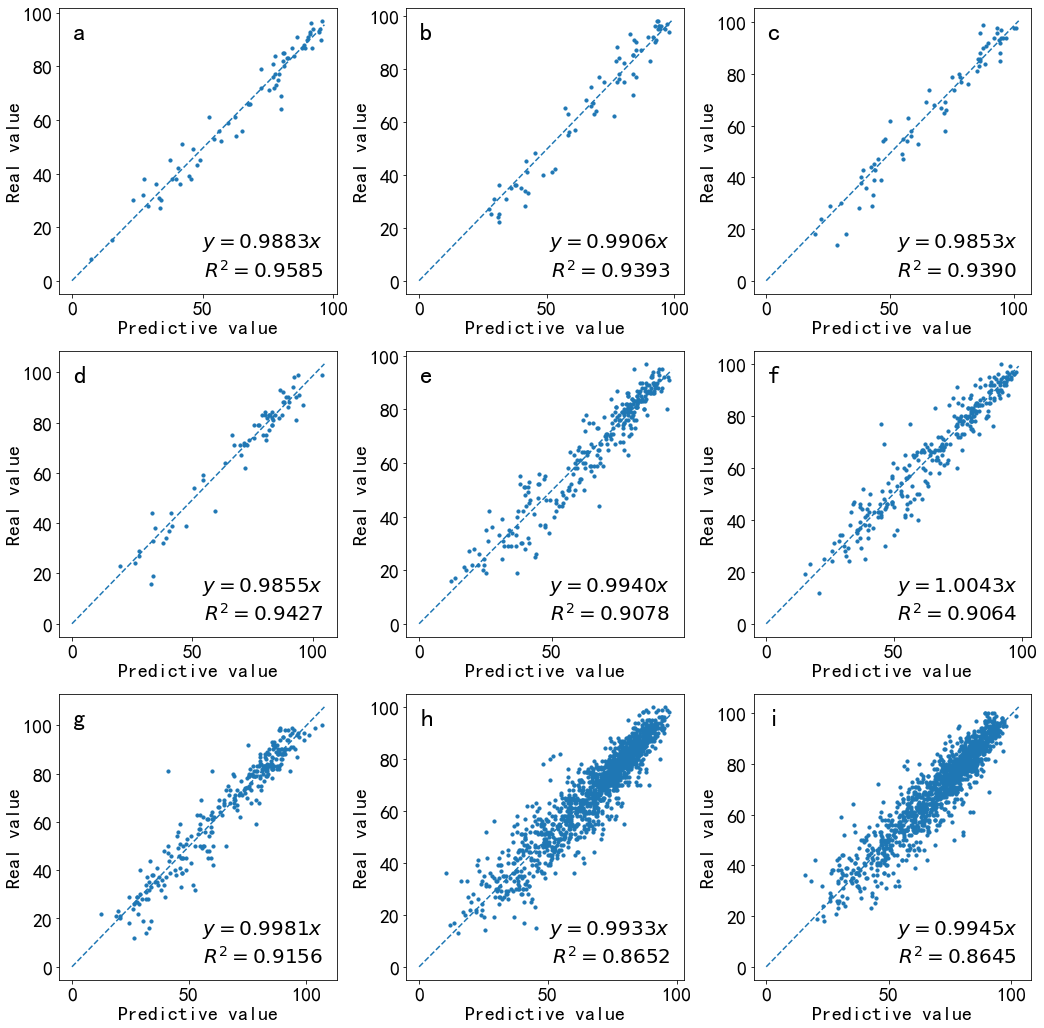

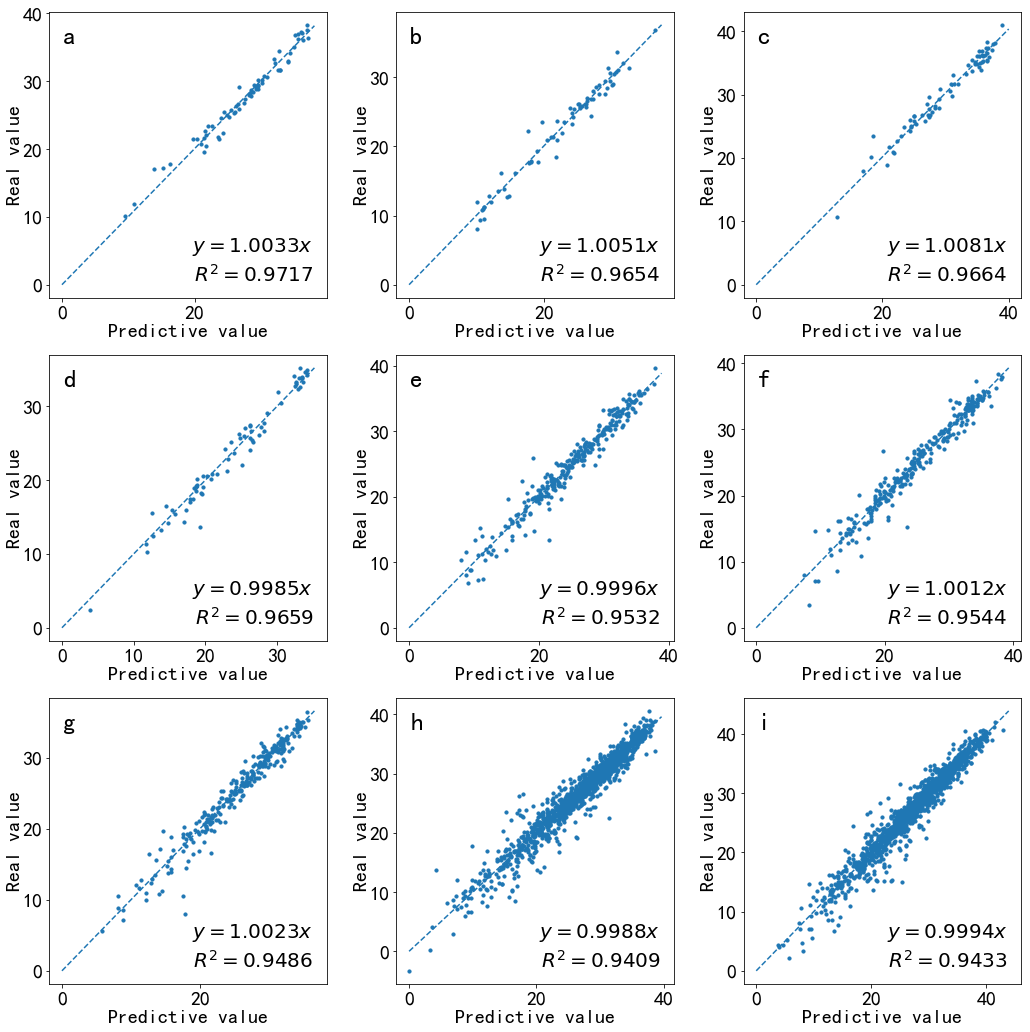

In [92]:
##验证插值精度
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

def statistics(tValue,vValue,dValue):
    """[summary]

    Args:
        tValue ([type]): real value
        vValue ([type]): predictive value
        dValue ([type]): abs difference of two values

    Returns:
        slope,r_square,pt,mae,rmse
    """
    n=len(tValue)
    rmse=np.sqrt(np.sum(dValue*dValue)/n)
    mae=np.mean(dValue)
    xx,xy=0,0
    for i in range(len(tValue)):
        xx+=np.power(vValue[i],2)
        xy+=vValue[i]*tValue[i]
    slope=xy/xx
    y_prd= slope * vValue
    regression=np.sum((y_prd-np.mean(tValue))**2)
    residual=np.sum((tValue-y_prd)**2)
    # print(regression,residual)
    r_square=regression/(regression+residual)

    t=slope * np.sqrt(n*np.var(vValue))/np.sqrt(residual/(n-2))
    pt=stats.t.sf(t,n-2)
    return slope,r_square,pt,mae,rmse

def mapping(path_data,path_zuotu,lan="en"):
    df = pd.read_csv(
        path_data,
        usecols=['tValue', 'date', 'series', 'vValue', 'month', 'year'],
        encoding='gbk')
    df=df.iloc[:81805,:]
    df["date"]=df["date"].astype("int").astype("str")
    df['month']=df['month'].astype("int").astype("str")
    df['year']=df['year'].astype("int").astype("str")
    df1=pd.read_csv(path_zuotu,usecols=['date','series','slope','r_square'],encoding='gbk')

    df2=pd.DataFrame()
    name=""
    for series in df1["series"].unique():
        i=0
        letter = list(map(chr, range(ord('a'), ord('z') + 1)))
        fig=plt.figure(figsize=(15,15),facecolor="white")
        fig.subplots_adjust(right=0.95,left=0.05,top=0.95,bottom=0.05,hspace=0.2,wspace=0.25)
        if lan=="ch":
            if "RHU" in series:
                # fig.suptitle('相对湿度（%）',fontsize=20)
                name="相对湿度"
            else:
                # fig.suptitle('温度（℃）',fontsize=20)
                name="温度"
        elif lan=="en":
            if "RHU" in series:
                # fig.suptitle('Relative Humidity(%)',fontsize=30)
                name = "Relative Humidity"
            else:
                # fig.suptitle('Temperature(℃)',fontsize=30)
                name = "Temperature"

        df3=df1[df1["series"]==series]
        for row in df3.itertuples():
            series=getattr(row,'series')
            date=str(getattr(row,'date'))
            if len(date)==8:
                df2=df[(df['series']==series) & (df['date']==date)]
            elif len(date)==6:
                df2=df[(df['series']==series) & (df['month']==date)]
            elif len(date)==4:
                df2=df[(df['series']==series) & (df['year']==date)]
            tValue=df2["tValue"]
            vValue=df2["vValue"]
            slope=getattr(row,"slope")
            r_square=getattr(row,'r_square')
            ax=fig.add_subplot(3,3,i+1)
            ax.text(0.05,0.95,horizontalalignment='left',verticalalignment='top',s=letter[i],transform=ax.transAxes,fontsize=25,fontweight='black')
            i+=1
            ax.scatter(vValue,tValue,s=10)
            x=np.array([0,np.max(vValue)+1])
            y=slope*x
            ax.plot(x,y,linestyle='--')
            # ax.set_title(date)
            if lan=="ch":
                ax.set_xlabel("预测值")
                ax.set_ylabel("真实值")
            elif lan=="en":
                ax.set_xlabel("Predictive value", fontsize=20)
                ax.set_ylabel("Real value",fontsize=20,labelpad=0)
            ax.tick_params(labelsize=20)

            ax.text(0.95,0.05,horizontalalignment='right',verticalalignment='bottom',s=f"$y={slope:.4f}x$\n$R^2={r_square:.4f}$",transform=ax.transAxes,fontsize=20)
        plt.savefig(fr'E:\高温热浪危险性论文\图片\英文\{name}.png',
                    dpi=fig.dpi,
                    bbox_inches='tight')  #保存图片


def main(path,path_zuotu):
    df=pd.read_csv(path,usecols=['tValue','date','series','vValue','dValue'])
    df=df.iloc[:81805,:]
    df["date"]=pd.to_datetime(df["date"].astype("int"),format="%Y%m%d")
    df["year"]=df["date"].dt.year
    df["month"]=df["date"].dt.strftime("%Y%m")
    df["date"]=df["date"].dt.strftime("%Y%m%d")
    df2=pd.DataFrame(columns=['date','series','slope','r_square','pt','mae','rmse'])
    df4=pd.DataFrame()
    for series in df["series"].unique():
        #按日
        df1=df[df["series"]==series]
        for date in df["date"].unique():
            tValue=np.array(df1[df1["date"]==date]["tValue"])
            vValue=np.array(df1[df1["date"]==date]["vValue"])
            dValue=np.abs(np.array(df1[df1["date"]==date]["dValue"],dtype=np.float))
            slope,r_square,pt,mae,rmse=statistics(tValue,vValue,dValue)
            df3=pd.DataFrame({'date':date,'series':series,'slope':slope,'r_square':r_square,'pt':pt,'mae':mae,'rmse':rmse},index=[0])
            df2=df2.append(df3)
        for month in df["month"].unique():
            tValue=np.array(df1[df1["month"]==month]["tValue"])
            vValue=np.array(df1[df1["month"]==month]["vValue"])
            dValue=np.abs(np.array(df1[df1["month"]==month]["dValue"],dtype=np.float))
            slope,r_square,pt,mae,rmse=statistics(tValue,vValue,dValue)
            df3=pd.DataFrame({'date':month,'series':series,'slope':slope,'r_square':r_square,'pt':pt,'mae':mae,'rmse':rmse},index=[0])
            df2=df2.append(df3)
        for year in df["year"].unique():
            tValue=np.array(df1[df1["year"]==year]["tValue"])
            vValue=np.array(df1[df1["year"]==year]["vValue"])
            dValue=np.abs(np.array(df1[df1["year"]==year]["dValue"],dtype=np.float))
            slope,r_square,pt,mae,rmse=statistics(tValue,vValue,dValue)
            df3=pd.DataFrame({'date':year,'series':series,'slope':slope,'r_square':r_square,'pt':pt,'mae':mae,'rmse':rmse},index=[0])
            df2=df2.append(df3)
        df3=df2[df2["series"]==series].sort_values(by="r_square",ascending=False)
        day=[i for i in np.array(df3["date"],dtype=str) if len(i)==8][:4]
        month=[i for i in np.array(df3["date"],dtype=str) if len(i)==6][:3]
        year=[int(i) for i in np.array(df3["date"],dtype=str) if len(i)==4][:2]
        date2pic=day+month+year
        for date in date2pic:
            df4=df4.append(df3[df3["date"]==date])
    df4.to_csv(path_zuotu,index=False)



# df2.to_csv(r"E:\研究生毕业论文\实验部分\插值精度\结果.csv")
if __name__ == "__main__":
    path_zuotu=r"E:\研究生毕业论文\实验部分\插值精度\作图.csv"
    path_data=r"E:\研究生毕业论文\实验部分\插值精度\updatePoint.csv"
    # main(path_data,path_zuotu)
    mapping(path_data,path_zuotu)

In [64]:
#不同变量图
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import pandas as pd
from osgeo import gdal
from matplotlib import cm
import os
from tqdm import trange
import tqdm


def statistics(data):
    pass


def calcu_fu(year):
    xiazhi = int(year * 0.2422 + 21.37) - int(year / 4) + 30
    if year % 2 == 0:
        D = 31
    else:
        D = 36
    Y = year
    GR = (D - int(Y / 4)) % 10
    one = GR + 10 - 1 + 61
    two = GR + 20 - 1 + 61
    if GR > 7:
        three = GR - 1
    else:
        three = GR + 9
    three = three - 1 + 91
    return xiazhi, one, two, three


def get_ticks(ticks, language):
    newticks = []
    for i in ticks:
        if i <= 30:
            if language == "ch":
                newticks.append(f"5月{str(i+1)}日")
            else:
                newticks.append(f"May.{str(i+1)}")
        elif 30 < i <= 60:
            if language == "ch":
                newticks.append(f"6月{str(i-30)}日")
            else:
                newticks.append(f"June.{str(i-30)}")
        elif 60 < i <= 91:
            if language == "ch":
                newticks.append(f"7月{str(i-60)}日")
            else:
                newticks.append(f"July.{str(i-60)}")
        elif 91 < i <= 122:
            if language == "ch":
                newticks.append(f"8月{str(i-91)}日")
            else:
                newticks.append(f"Aug.{str(i-91)}")
        else:
            if language == "ch":
                newticks.append(f"9月{str(i-122)}日")
            else:
                newticks.append(f"Sept.{str(i-122)}")
    return newticks


def mapping(img_path,
            output,
            title_keys=None,
            title=None,
            statistics=False,
            language='en',
            ):
    def init_background(mapn, axn,unit,key, data_path=None, statistics=False):
        china_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国全境"
        world_path = r"E:\范围shp文件\世界地图\世界国家"
        line_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国边界线"
        province_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国省份分界线"
        mapn.readshapefile(world_path,
                           name='world',
                           drawbounds=False,
                           default_encoding='gbk')
        df = pd.DataFrame(mapn.world_info)
        not_china_index = np.array(df[df["NAME"] != "CHINA"].index)
        del df
        p1 = PatchCollection(
            [
                Polygon(i)
                for i in np.array(mapn.world, dtype=object)[not_china_index]
            ],
            edgecolors='black',
            facecolors='lightgray',
            linewidths=0.2,
        )
        axn.add_collection(p1)
        del p1
        mapn.readshapefile(china_path, name='china')

        p2 = PatchCollection(
            [Polygon(i) for i in np.array(mapn.china, dtype=object)],
            edgecolors='black',
            facecolors='lightgray',
            linewidth=0.8)
        axn.add_collection(p2)
        del p2
        mapn.readshapefile(line_path, name='china_line', linewidth=0.8)
        if data_path is not None:
            ds = gdal.Open(data_path)
            data = ds.ReadAsArray()
            (xmin, xl, _, ymax, _, _) = ds.GetGeoTransform()
            width = data.shape[1]
            height = data.shape[0]
            ndv = ds.GetRasterBand(1).GetNoDataValue()

            if "slope" in data_path:
                data_b = data[data != ndv]
                data_c = data_b[data_b >= 0]

                percent = len(data_c) / len(data_b)
                print(data_path, percent)

            data = np.ma.masked_where(data == ndv, data)
            data_min, data_max = np.nanmin(data), np.nanmax(data)
            if statistics:
                data1 = data[data != np.ma.masked]
                total_num = 9576022
                result = {
                    # 'year': int(data_path.split("\\")[-1][:4]),
                    'name': data_path.split("\\")[-1][:-4],
                    'min': data_min,
                    'max': data_max,
                    'per_min': len(data1[data1 == data_min]) / total_num,
                    'per_max': len(data1[data1 == data_max]) / total_num,
                    'min_per_1': np.average(np.sort(data1)[:2000]),
                    'max_per_1': np.average(np.sort(data1)[-2000:]),
                    'average': np.average(data1),
                }
                if "日期" in data_path:
                    xiazhi, one, two, three = calcu_fu(2010
                    )  # int(data_path.split("\\")[-1][2:4])
                    if "开始日期" in data_path:
                        result["percentage"] = len(data1) / total_num
                        result["per_xiazhi"] = len(
                            data1[data1 < xiazhi]) / total_num
                        result["per_xiazhi2one"] = len(data1[
                            (one > data1) & (data1 >= xiazhi)]) / total_num
                        result["per_one2two"] = len(
                            data1[(two > data1) & (data1 >= one)]) / total_num
                        result["per_two2three"] = len(data1[
                            (three > data1) & (data1 >= two)]) / total_num
                        result["per_three"] = len(
                            data1[data1 >= three]) / total_num
                    if "结束日期" in data_path:
                        result["per_xiazhi"] = len(
                            data1[data1 < xiazhi]) / total_num
                        result["per_xiazhi2one"] = len(data1[
                            (one > data1) & (data1 >= xiazhi)]) / total_num
                        result["per_one2two"] = len(
                            data1[(two > data1) & (data1 >= one)]) / total_num
                        result["per_two2three"] = len(data1[
                            (three > data1) & (data1 >= two)]) / total_num
                        result["per_three"] = len(
                            data1[data1 >= three]) / total_num
                del data1
                result = pd.DataFrame(result, index=[0])
            ymin = ymax - height * xl
            xmax = xmin + width * xl
            x = np.linspace(xmin, xmax, width)
            y = np.linspace(ymin, ymax, height)[::-1]
            xx, yy = np.meshgrid(x, y)
            if "危险性" in data_path:
                cntr = mapn.contourf(xx, yy, data, levels=5, cmap='RdYlBu_r')
                ticks=[0.4,1.2,2.0,2.8,3.6]
            else:
                ticks = np.sort(
                list(set((np.linspace(data_min, data_max, 20) /
                        unit).astype(int)))) * unit
                if "slope" in data_path:
                    if data_min>=0:
                        colors = mpl.cm.get_cmap("RdYlBu_r")(np.linspace(0.5,1,9))
                    elif data_max<0:
                        colors = mpl.cm.get_cmap("RdYlBu_r")(np.linspace(0,0.5,9))
                    cntr=mapn.contourf(xx, yy, data, colors=colors)
                else:
                    cntr = mapn.contourf(xx, yy, data, levels=80, cmap='RdYlBu_r')

                if ticks[0] < data_min:
                    ticks = np.delete(ticks, 0)
                if ticks[-1] > data_max:
                    ticks = np.delete(ticks, -1)
                if "日期" in key:
                    xiazhi, one, two, three = calcu_fu(2010) # 2010
                    if data_min != 0 and data_max != 152:
                        ticks = [31, xiazhi, 61, one, two, 92, three, 123]
                    elif data_min != 0 and data_max == 152:
                        ticks = [31, xiazhi, 61, one, two, 92, three, 123, 152]
                    elif data_min == 0 and data_max != 152:
                        ticks = [0, 31, xiazhi, 61, one, two, 92, three, 123]
                    else:
                        ticks = [0, 31, xiazhi, 61, one, two, 92, three, 123, 152]
            colorbar = mapn.colorbar(cntr, size='3.5%', ticks=ticks)
            colorbar.ax.tick_params(labelsize=15)

            if "日期" in key and "slope" not in key:
                newticks = get_ticks(ticks, language)
                colorbar.set_ticklabels(newticks)
            if "危险性" in key:
                newticks=["Low","Medium Low","Middle","Medium High","High"]
                colorbar.set_ticklabels(newticks)
            del data
            del ds
            mapn.readshapefile(
                province_path,
                name='province',
                linewidth=0.2,
            )
            if statistics:
                return result
            else:
                pass

    # 用来正常显示中文
    plt.rcParams['font.sans-serif'] = ['SimHei']
    # 用来正常显示负号
    plt.rcParams['axes.unicode_minus'] = False
    # print(title_keys)
    # sfigs = fig.subfigures(5, 2)
    results = pd.DataFrame()
    for i in trange(len(title_keys)):
        # if not os.path.exists(
        #         fr"E:\高温热浪危险性论文\图片\英文\分年份热浪\{title_keys[i]}.png"):
        fig = plt.figure(figsize=(24, 27), dpi=300,facecolor="white")
        data_path = os.path.join(img_path, title_keys[i] + ".tif")
        left, bottom, width, height = 0.025, 0.05, 0.95, 0.95
        sfig = fig.add_subfigure()
        ax1 = fig.add_axes([left, bottom, width, height])
        map1 = Basemap(llcrnrlon=73,
                       llcrnrlat=18,
                       urcrnrlon=136,
                       urcrnrlat=54,
                       ax=ax1)
        key=title_keys[i]
        unit = title[title_keys[i]][2]
        if statistics:
            result = init_background(
                map1, ax1,unit,key, data_path, True)
            result['c_name'] = title[result.iloc[0]['name']][0]
            result['name'] = title[result.iloc[0]['name']][1]
            if results.empty:
                results = result
            else:
                results = pd.concat([results, result], ignore_index=True)
        else:
            init_background(map1, ax1, unit,key,data_path)

        map1.drawparallels(np.linspace(20, 50, 7),
                           labels=[1, 0, 0, 0],
                           linewidth=0,
                           fontsize=15)
        map1.drawmeridians(np.linspace(75, 135, 7),
                           labels=[0, 0, 0, 1],
                           linewidth=0,
                           fontsize=15)
        ax2 = fig.add_axes([0.775, 0.15, 0.15, 0.3])
        map2 = Basemap(llcrnrlon=106,
                       llcrnrlat=2,
                       urcrnrlon=124,
                       urcrnrlat=23,
                       ax=ax2)
        if language == 'ch':
            ax2.text(0.98,
                     0.02,
                     horizontalalignment='right',
                     verticalalignment='bottom',
                     s=f"中国南海",
                     transform=ax2.transAxes,
                     fontsize=10)
            # fig.text(0.966, 0.875, '高度表（米）', fontsize=8)
            # fig.suptitle(title[title_keys[i]][0], y=0.9)
        elif language == 'en':
            ax2.text(
                0.98,
                0.02,
                horizontalalignment='right',
                verticalalignment='bottom',
                s=f"South China Sea",
                transform=ax2.transAxes,
                fontsize=15,
            )
            # fig.text(0.96, 0.88, 'Elevation(m)', fontsize=8)
            # fig.suptitle(title[title_keys[i]][1], y=0.9)
        init_background(map2, ax2,unit,key)
        fig.savefig(fr"E:\高温热浪危险性论文\图片\英文\分月份TI\{title_keys[i]}.png",
                    dpi=fig.dpi,
                    bbox_inches='tight')
        plt.close()
        del map1, map2
    # if not results.empty:
    #     results.to_csv(r"E:\高温热浪危险性论文\表格\统计mean.csv", index_label=False)

title_keys = np.array(
    [
        "05",
        # "slope_05",
        "06",
        # "slope_06",
        "07",
        # "slope_07",
        "08",
        # "slope_08",
        "09",
        # "slope_09",
        # "slope_whole",
        # "slope_热浪次数(mean)_1",
        # "slope_热浪次数(mean)_2",
        # "slope_热浪次数(mean)_3",
        # "slope_热浪次数(mean)",
        # "slope_热浪日数(3)_1",
        # "slope_热浪日数(3)_2",
        # "slope_热浪日数(3)_3",
        # "slope_热浪日数(3)",
        # "slope_最长热浪持续日数",
        # "slope_最大单日热浪指数(3)",
        # "slope_热浪开始日期(3)",
        # "slope_热浪结束日期(3)",
        # "slope_最大热浪HI指数极差(3)",
        # "热浪次数(mean)_1",
        # "热浪次数(mean)_2",
        # "热浪次数(mean)_3",
        # "热浪次数(mean)",
        # "热浪日数(3)_1",
        # "热浪日数(3)_2",
        # "热浪日数(3)_3",
        # "热浪日数(3)",
        # "最长热浪持续日数",
        # "最大单日热浪指数(3)",
        # "热浪开始日期(3)",
        # "热浪结束日期(3)",
        # "最大热浪HI指数极差(3)",
        # "危险性_重分类",
        # "危险性_重分类1",
        # "slope_危险性_重分类",
    ],
    dtype=str)

title = {
    "05": ["1990-2019年5月平均炎热指数", "Mean TI of May during 1990-2019", 10],
    "06": ["1990-2019年6月平均炎热指数", "Mean TI of June during 1990-2019", 10],
    "07": ["1990-2019年7月平均炎热指数", "Mean TI of July during 1990-2019", 10],
    "08": ["1990-2019年8月平均炎热指数", "Mean TI of August during 1990-2019", 10],
    "09": ["1990-2019年9月平均炎热指数", "Mean TI of September during 1990-2019", 10],
    "slope_05": [
        "1990-2019年5月平均炎热指数变化的斜率", "Slope of mean TI of May during 1990-2019",
        0.1
    ],
    "slope_06": [
        "1990-2019年6月平均炎热指数变化的斜率", "Slope of mean TI of June during 1990-2019",
        0.1
    ],
    "slope_07": [
        "1990-2019年7月平均炎热指数变化的斜率", "Slope of mean TI of July during 1990-2019",
        0.1
    ],
    "slope_08": [
        "1990-2019年8月平均炎热指数变化的斜率",
        "Slope of mean TI of August during 1990-2019", 0.1
    ],
    "slope_09": [
        "1990-2019年9月平均炎热指数变化的斜率",
        "Slope of mean TI of September during 1990-2019", 0.1
    ],
    "slope_whole": [
        "1990-2019年月平均炎热指数变化的斜率", "Slope of mean monthly TI during 1990-2019",
        0.01
    ],
    "slope_热浪次数(mean)_1":
    ["1990-2019年轻度热浪次数变化的斜率", "Slope of HWF_1 during 1990-2019", 0.1],
    "slope_热浪次数(mean)_2":
    ["1990-2019年中度热浪次数变化的斜率", "Slope of HWF_2 during 1990-2019", 0.1],
    "slope_热浪次数(mean)_3":
    ["1990-2019年重度热浪次数变化的斜率", "Slope of HWF_3 during 1990-2019", 0.1],
    "slope_热浪次数(mean)":
    ["1990-2019年热浪总次数变化的斜率", "Slope of HWF during 1990-2019", 0.1],
    "slope_热浪日数(3)_1":
    ["1990-2019年轻度热浪发生天数变化的斜率", "Slope of HWTD_1 during 1990-2019", 0.5],
    "slope_热浪日数(3)_2":
    ["1990-2019年中度热浪发生天数变化的斜率", "Slope of HWTD_2 during 1990-2019", 0.2],
    "slope_热浪日数(3)_3":
    ["1990-2019年重度热浪发生天数变化的斜率", "Slope of HWTD_3 during 1990-2019", 0.5],
    "slope_热浪日数(3)":
    ["1990-2019年热浪发生总天数变化的斜率", "Slope of HWTD during 1990-2019", 0.5],
    "slope_最长热浪持续日数":
    ["1990-2019年单次热浪最长持续天数变化的斜率", "Slope of HWMD during 1990-2019", 0.2],
    "slope_最大单日热浪指数(3)":
    ["1990-2019年最大日热浪指数变化的斜率", "Slope of HWMHI during 1990-2019", 0.3],
    "slope_热浪开始日期(3)":
    ["1990-2019年热浪开始日期变化的斜率", "Slope of HWSD during 1990-2019", 3],
    "slope_热浪结束日期(3)":
    ["1990-2019年热浪结束日期变化的斜率", "Slope of HWED during 1990-2019", 3],
    "slope_最大热浪HI指数极差(3)": [
        "1990-2019年最大单次热浪指数极差变化的斜率", "Slope of HWMRHI during 1990-2019", 0.5
    ],
    "热浪次数(mean)_1": [
        "年平均轻度热浪次数", "Annual average HWF_1", 1
    ],
    "热浪次数(mean)_2": [
        "年平均中度热浪次数", "Annual average HWF_2", 1
    ],
    "热浪次数(mean)_3": [
        "年平均重度热浪次数", "Annual average HWF_3", 1
    ],
    "热浪次数(mean)": [
        "年平均热浪总次数", "Annual average HWF", 1
    ],
    "热浪日数(3)_1": [
        "年平均轻度热浪发生天数", "Annual average HWTD_1", 5
    ],
    "热浪日数(3)_2": [
        "年平均中度热浪发生天数", "Annual average HWTD_2", 4
    ],
    "热浪日数(3)_3": [
        "年平均重度热浪发生天数", "Annual average HWTD_3", 5
    ],
    "热浪日数(3)": [
        "年平均热浪发生总天数", "Annual average HWTD", 10
    ],
    "最长热浪持续日数": [
        "年平均单次热浪最长持续天数", "Annual average HWMD", 3
    ],
    "最大单日热浪指数(3)": [
        "年平均最大日热浪指数", "Annual average HWMHI", 4
    ],
    "热浪开始日期(3)": [
        "年平均热浪开始日期", "Annual average HWSD", 3
    ],
    "热浪结束日期(3)": [
        "年平均热浪结束日期", "Annual average HWED", 3
    ],
    "最大热浪HI指数极差(3)": [
        "年平均最大单次热浪指数极差", "Annual average HWMRHI", 4
    ],
    "危险性_重分类1":["危险性","Heatwave hazard",1]
}
img_path = r"G:\dem_chazhi\result\时间序列"
img_path_1 = r"G:\dem_chazhi\result\热浪不同指标结果"
# for year in range(2000, 2020):
#     year = str(year)
#     keys = [
#         # f"{year}_热浪次数(mean)_1", f"{year}_热浪次数(mean)_2", f"{year}_热浪次数(mean)_3",
#         # f"{year}_热浪次数(mean)",
#         # f"{year}_热浪日数(3)_1", f"{year}_热浪日数(3)_2",
#         # f"{year}_热浪日数(3)_3", f"{year}_热浪日数(3)", f"{year}_最长热浪持续日数",
#         f"{year}_最大单日热浪指数(3)",
#         # f"{year}_热浪开始日期(3)", f"{year}_热浪结束日期(3)",
#         # f"{year}_最大热浪HI指数极差(3)"
#     ]
#     title_keys = np.concatenate((title_keys, keys))
#     # title[f"{year}_热浪次数(mean)_1"] = [f"{year}年轻度热浪次数", f"HWF_1 in {year}", 2]
#     # title[f"{year}_热浪次数(mean)_2"] = [f"{year}年中度热浪次数", f"HWF_2 in {year}", 2]
#     # title[f"{year}_热浪次数(mean)_3"] = [f"{year}年重度热浪次数", f"HWF_3 in {year}", 2]
#     # title[f"{year}_热浪次数(mean)"] = [f"{year}年热浪次数", f"HWF in {year}", 2]
#     # title[f"{year}_热浪日数(3)_1"] = [f"{year}年轻度热浪天数", f"HWTD_1 in {year}", 5]
#     # title[f"{year}_热浪日数(3)_2"] = [f"{year}年中度热浪天数", f"HWTD_2 in {year}", 5]
#     # title[f"{year}_热浪日数(3)_3"] = [f"{year}年重度热浪天数", f"HWTD_3 in {year}", 5]
#     # title[f"{year}_热浪日数(3)"] = [f"{year}年热浪总天数", f"HWTD in {year}", 10]
#     # title[f"{year}_最长热浪持续日数"] = [f"{year}年单次热浪最长持续天数", f"HWMD in {year}", 5]
#     title[f"{year}_最大单日热浪指数(3)"] = [f"{year}年最大日热浪指数", f"HWMHI in {year}", 5]
#     # title[f"{year}_热浪开始日期(3)"] = [f"{year}年热浪开始日期", f"HWSD in {year}", 20]
#     # title[f"{year}_热浪结束日期(3)"] = [f"{year}年热浪结束日期", f"HWED in {year}", 20]
#     # title[f"{year}_最大热浪HI指数极差(3)"] = [
#     #     f"{year}年最大单次热浪指数极差", f"HWMRHI in {year}", 10
#     # ]
img_path_2 = r"G:\dem_chazhi\result\mean"
img_path_3 = r"G:\dem_chazhi\result\危险性"
mapping(img_path, title_keys, title, False, language='en')


100%|██████████| 5/5 [02:59<00:00, 35.93s/it]


In [ ]:
import os
import numpy
import matplotlib.pyplot as plt
import pandas as pd


def get_ticks(ticks, language="en"):
    newticks = []
    for i in ticks:
        if i <= 30:
            if language == "ch":
                newticks.append(f"5月{str(i+1)}日")
            else:
                newticks.append(f"May.{str(i+1)}")
        elif 30 < i <= 60:
            if language == "ch":
                newticks.append(f"6月{str(i-30)}日")
            else:
                newticks.append(f"June.{str(i-30)}")
        elif 60 < i <= 91:
            if language == "ch":
                newticks.append(f"7月{str(i-60)}日")
            else:
                newticks.append(f"July.{str(i-60)}")
        elif 91 < i <= 122:
            if language == "ch":
                newticks.append(f"8月{str(i-91)}日")
            else:
                newticks.append(f"Aug.{str(i-91)}")
        else:
            if language == "ch":
                newticks.append(f"9月{str(i-122)}日")
            else:
                newticks.append(f"Sept.{str(i-122)}")
    return newticks


filepath = r"E:\高温热浪危险性论文\表格\统计.xlsx"
fig,ax=plt.subplots(dpi=200)
df=pd.read_excel(filepath,'Sheet1')
ax.set_xlabel("year")
ax.set_xticks([2000, 2004, 2009, 2014, 2019])

# #开始和结束日期
# fig.suptitle("HWSD and HWED during 2000-2019",y=0.95)
# ax.set_ylabel("date")
# ticks = [0,31, 61,92, 123,152]
# ax.set_yticks(
#     ticks, labels=["May.1", "June.1", "July.1", "Aug.1", "Sept.1", "Sept.30"])

# ax.plot(df['year'], df["HWSD"], label="HWSD")
# ax.scatter(df['year'], df["HWSD"],s=15)
# ax.plot(df['year'], df["HWED"], label="HWED")
# ax.scatter(df['year'], df["HWED"], s=15)
# ax.plot(df['year'], df["HWSD_min"], label="HWSD_min")
# ax.scatter(df['year'], df["HWSD_min"], s=15)
# ax.plot(df['year'], df["HWED_max"], label="HWED_max")
# ax.scatter(df['year'], df["HWED_max"], s=15)
# ax.legend(bbox_to_anchor=(0.5, -0.15), loc=9, ncol=4)
# fig.savefig(r"E:\高温热浪危险性论文\图片\英文\date.png", bbox_inches='tight')

# # 热浪次数和天数
# fig.suptitle("HWMD_max during 2000-2019", y=0.95)
# ax.set_ylabel("days")
# ax.plot(df['year'], df["HWF"], label="HWF")
# ax.plot(df['year'], df["HWF_1"], label="HWF_1")
# ax.plot(df['year'], df["HWF_2"], label="HWF_2")
# ax.plot(df['year'], df["HWF_3"], label="HWF_3")
# ax.plot(df['year'], df["HWF_max"], label="HWF_max")
# ax.plot(df['year'], df["HWF_1_max"], label="HWF_1_max")
# ax.plot(df['year'], df["HWF_2_max"], label="HWF_2_max")
# ax.plot(df['year'], df["HWF_3_max"], label="HWF_3_max")
# ax.plot(df['year'], df["HWTD"], label="HWTD")
# ax.plot(df['year'], df["HWTD_1"], label="HWTD_1")
# ax.plot(df['year'], df["HWTD_2"], label="HWTD_2")
# ax.plot(df['year'], df["HWTD_3"], label="HWTD_3")
# ax.plot(df['year'], df["HWTD_max"], label="HWTD_max")
# ax.plot(df['year'], df["HWTD_1_max"], label="HWTD_1_max")
# ax.plot(df['year'], df["HWTD_2_max"], label="HWTD_2_max")
# ax.plot(df['year'], df["HWTD_3_max"], label="HWTD_3_max")
# ax.plot(df['year'], df["HWMD"], label="HWMD")
# ax.plot(df['year'], df["HWMD_max"], label="HWMD_max")
# ax.legend(bbox_to_anchor=(0.5, -0.15), loc=9, ncol=4)
# fig.savefig(r"E:\高温热浪危险性论文\图片\英文\HWMD_max.png", bbox_inches='tight')

# # 热浪指数
# fig.suptitle("HWMRHI_max during 2000-2019", y=0.95)
# ax.plot(df['year'], df["HWMHI"], label="HWMHI")
# ax.plot(df['year'], df["HWMHI_max"], label="HWMHI_max")
# ax.plot(df['year'], df["HWMRHI"], label="HWMRHI")
# ax.plot(df['year'], df["HWMRHI_max"], label="HWMRHI_max")
# ax.legend(bbox_to_anchor=(0.5, -0.15), loc=9, ncol=4)
# fig.savefig(r"E:\高温热浪危险性论文\图片\英文\HWMRHI_max.png", bbox_inches='tight')

# 热浪发生百分比
fig.suptitle("Percentage of HW during 2000-2019", y=0.95)
ax.plot(df['year'], df["percentage"], label="percentage")
ax.plot(df['year'], df["e_xiazhi"], label="e_xiazhi")
ax.plot(df['year'], df["e_xiazhi2one"], label="e_xiazhi2one")
ax.plot(df['year'], df["e_one2two"], label="e_one2two")
ax.plot(df['year'], df["e_two2three"], label="e_two2three")
ax.plot(df['year'], df["e_three"], label="e_three")
ax.plot(df['year'], df["s_xiazhi"], label="s_xiazhi")
ax.plot(df['year'], df["s_xiazhi2one"], label="s_xiazhi2one")
ax.plot(df['year'], df["s_one2two"], label="s_one2two")
ax.plot(df['year'], df["s_two2three"], label="s_two2three")
ax.plot(df['year'], df["s_three"], label="s_three")
ax.legend(bbox_to_anchor=(0.5, -0.15), loc=9, ncol=3)
fig.savefig(r"E:\高温热浪危险性论文\图片\英文\percentage.png", bbox_inches='tight')


In [5]:
#不同变量图 备份
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import pandas as pd
from osgeo import gdal
from matplotlib import cm
import os
from tqdm import trange
import tqdm


def statistics(data):
    pass


def calcu_fu(year):
    xiazhi = int(year * 0.2422 + 21.37) - int(year / 4) + 30
    if year % 2 == 0:
        D = 31
    else:
        D = 36
    Y = year
    GR = (D - int(Y / 4)) % 10
    one = GR + 10 - 1 + 61
    two = GR + 20 - 1 + 61
    if GR > 7:
        three = GR - 1
    else:
        three = GR + 9
    three = three - 1 + 91
    return xiazhi, one, two, three


def get_ticks(ticks, language):
    newticks = []
    for i in ticks:
        if i <= 30:
            if language == "ch":
                newticks.append(f"5月{str(i+1)}日")
            else:
                newticks.append(f"May.{str(i+1)}")
        elif 30 < i <= 60:
            if language == "ch":
                newticks.append(f"6月{str(i-30)}日")
            else:
                newticks.append(f"June.{str(i-30)}")
        elif 60 < i <= 91:
            if language == "ch":
                newticks.append(f"7月{str(i-60)}日")
            else:
                newticks.append(f"July.{str(i-60)}")
        elif 91 < i <= 122:
            if language == "ch":
                newticks.append(f"8月{str(i-91)}日")
            else:
                newticks.append(f"Aug.{str(i-91)}")
        else:
            if language == "ch":
                newticks.append(f"9月{str(i-122)}日")
            else:
                newticks.append(f"Sept.{str(i-122)}")
    return newticks


def mapping(img_path,
            title_keys=None,
            title=None,
            statistics=False,
            language='ch'):
    def init_background(mapn, axn,unit,key, data_path=None, statistics=False):
        china_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国全境"
        world_path = r"E:\范围shp文件\世界地图\世界国家"
        line_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国边界线"
        province_path = r"E:\研究生毕业论文\数据和处理（原始资料）\审图号 GS（2019）1719 号地图的底图数据\中国省级地图GS（2019）1719号\中国省份分界线"
        mapn.readshapefile(world_path,
                           name='world',
                           drawbounds=False,
                           default_encoding='gbk')
        df = pd.DataFrame(mapn.world_info)
        not_china_index = np.array(df[df["NAME"] != "CHINA"].index)
        del df
        p1 = PatchCollection(
            [
                Polygon(i)
                for i in np.array(mapn.world, dtype=object)[not_china_index]
            ],
            edgecolors='black',
            facecolors='lightgray',
            linewidths=0.2,
        )
        axn.add_collection(p1)
        del p1
        mapn.readshapefile(china_path, name='china')

        p2 = PatchCollection(
            [Polygon(i) for i in np.array(mapn.china, dtype=object)],
            edgecolors='black',
            facecolors='lightgray',
            linewidth=0.8)
        axn.add_collection(p2)
        del p2
        mapn.readshapefile(line_path, name='china_line', linewidth=0.8)
        if data_path is not None:
            ds = gdal.Open(data_path)
            data = ds.ReadAsArray()
            (xmin, xl, _, ymax, _, _) = ds.GetGeoTransform()
            width = data.shape[1]
            height = data.shape[0]
            ndv = ds.GetRasterBand(1).GetNoDataValue()

            if "slope" in data_path:
                data_b = data[data != ndv]
                data_c = data_b[data_b >= 0]

                percent = len(data_c) / len(data_b)
                print(data_path, percent)

            data = np.ma.masked_where(data == ndv, data)
            data_min, data_max = np.nanmin(data), np.nanmax(data)
            if statistics:
                data1 = data[data != np.ma.masked]
                total_num = 9576022
                result = {
                    # 'year': int(data_path.split("\\")[-1][:4]),
                    'name': data_path.split("\\")[-1][:-4],
                    'min': data_min,
                    'max': data_max,
                    'per_min': len(data1[data1 == data_min]) / total_num,
                    'per_max': len(data1[data1 == data_max]) / total_num,
                    'min_per_1': np.average(np.sort(data1)[:2000]),
                    'max_per_1': np.average(np.sort(data1)[-2000:]),
                    'average': np.average(data1),
                }
                if "日期" in data_path:
                    xiazhi, one, two, three = calcu_fu(2010
                    )  # int(data_path.split("\\")[-1][2:4])
                    if "开始日期" in data_path:
                        result["percentage"] = len(data1) / total_num
                        result["per_xiazhi"] = len(
                            data1[data1 < xiazhi]) / total_num
                        result["per_xiazhi2one"] = len(data1[
                            (one > data1) & (data1 >= xiazhi)]) / total_num
                        result["per_one2two"] = len(
                            data1[(two > data1) & (data1 >= one)]) / total_num
                        result["per_two2three"] = len(data1[
                            (three > data1) & (data1 >= two)]) / total_num
                        result["per_three"] = len(
                            data1[data1 >= three]) / total_num
                    if "结束日期" in data_path:
                        result["per_xiazhi"] = len(
                            data1[data1 < xiazhi]) / total_num
                        result["per_xiazhi2one"] = len(data1[
                            (one > data1) & (data1 >= xiazhi)]) / total_num
                        result["per_one2two"] = len(
                            data1[(two > data1) & (data1 >= one)]) / total_num
                        result["per_two2three"] = len(data1[
                            (three > data1) & (data1 >= two)]) / total_num
                        result["per_three"] = len(
                            data1[data1 >= three]) / total_num
                del data1
                result = pd.DataFrame(result, index=[0])
            ymin = ymax - height * xl
            xmax = xmin + width * xl
            x = np.linspace(xmin, xmax, width)
            y = np.linspace(ymin, ymax, height)[::-1]
            xx, yy = np.meshgrid(x, y)
            if "危险性" in data_path:
                cntr = mapn.contourf(xx, yy, data, levels=5, cmap='RdYlBu_r')
                ticks=[0.4,1.2,2.0,2.8,3.6]
            else:
                ticks = np.sort(
                list(set((np.linspace(data_min, data_max, 20) /
                        unit).astype(int)))) * unit
                if "slope" in data_path:
                    if data_min>=0:
                        colors = mpl.cm.get_cmap("RdYlBu_r")(np.linspace(0.5,1,9))
                    elif data_max<0:
                        colors = mpl.cm.get_cmap("RdYlBu_r")(np.linspace(0,0.5,9))
                    cntr=mapn.contourf(xx, yy, data, colors=colors)
                else:
                    cntr = mapn.contourf(xx, yy, data, levels=80, cmap='RdYlBu_r')

                if ticks[0] < data_min:
                    ticks = np.delete(ticks, 0)
                if ticks[-1] > data_max:
                    ticks = np.delete(ticks, -1)
                if "日期" in key:
                    xiazhi, one, two, three = calcu_fu(2010) # 2010
                    if data_min != 0 and data_max != 152:
                        ticks = [31, xiazhi, 61, one, two, 92, three, 123]
                    elif data_min != 0 and data_max == 152:
                        ticks = [31, xiazhi, 61, one, two, 92, three, 123, 152]
                    elif data_min == 0 and data_max != 152:
                        ticks = [0, 31, xiazhi, 61, one, two, 92, three, 123]
                    else:
                        ticks = [0, 31, xiazhi, 61, one, two, 92, three, 123, 152]
            colorbar = mapn.colorbar(cntr, size='3.5%', ticks=ticks)
            colorbar.ax.tick_params(labelsize=15)

            if "日期" in key and "slope" not in key:
                newticks = get_ticks(ticks, language)
                colorbar.set_ticklabels(newticks)
            if "危险性" in key:
                newticks=["Low","Medium Low","Middle","Medium High","High"]
                colorbar.set_ticklabels(newticks)
            del data
            del ds
            mapn.readshapefile(
                province_path,
                name='province',
                linewidth=0.2,
            )
            if statistics:
                return result
            else:
                pass

    # 用来正常显示中文
    plt.rcParams['font.sans-serif'] = ['SimHei']
    # 用来正常显示负号
    plt.rcParams['axes.unicode_minus'] = False
    # print(title_keys)
    # sfigs = fig.subfigures(5, 2)
    results = pd.DataFrame()
    for i in trange(len(title_keys)):
        # if not os.path.exists(
        #         fr"E:\高温热浪危险性论文\图片\英文\分年份热浪\{title_keys[i]}.png"):
        fig = plt.figure(figsize=(24, 27), dpi=300,facecolor="white")
        data_path = os.path.join(img_path, title_keys[i] + ".tif")
        left, bottom, width, height = 0.025, 0.05, 0.95, 0.95
        # sfig = sfigs[i][j]
        ax1 = fig.add_axes([left, bottom, width, height])
        map1 = Basemap(llcrnrlon=73,
                       llcrnrlat=18,
                       urcrnrlon=136,
                       urcrnrlat=54,
                       ax=ax1)
        key=title_keys[i]
        unit = title[title_keys[i]][2]
        if statistics:
            result = init_background(
                map1, ax1,unit,key, data_path, True)
            result['c_name'] = title[result.iloc[0]['name']][0]
            result['name'] = title[result.iloc[0]['name']][1]
            if results.empty:
                results = result
            else:
                results = pd.concat([results, result], ignore_index=True)
        else:
            init_background(map1, ax1, unit,key,data_path)

        map1.drawparallels(np.linspace(20, 50, 7),
                           labels=[1, 0, 0, 0],
                           linewidth=0,
                           fontsize=15)
        map1.drawmeridians(np.linspace(75, 135, 7),
                           labels=[0, 0, 0, 1],
                           linewidth=0,
                           fontsize=15)
        ax2 = fig.add_axes([0.775, 0.15, 0.15, 0.3])
        map2 = Basemap(llcrnrlon=106,
                       llcrnrlat=2,
                       urcrnrlon=124,
                       urcrnrlat=23,
                       ax=ax2)
        if language == 'ch':
            ax2.text(0.98,
                     0.02,
                     horizontalalignment='right',
                     verticalalignment='bottom',
                     s=f"中国南海",
                     transform=ax2.transAxes,
                     fontsize=10)
            # fig.text(0.966, 0.875, '高度表（米）', fontsize=8)
            # fig.suptitle(title[title_keys[i]][0], y=0.9)
        elif language == 'en':
            ax2.text(
                0.98,
                0.02,
                horizontalalignment='right',
                verticalalignment='bottom',
                s=f"South China Sea",
                transform=ax2.transAxes,
                fontsize=15,
            )
            # fig.text(0.96, 0.88, 'Elevation(m)', fontsize=8)
            # fig.suptitle(title[title_keys[i]][1], y=0.9)
        init_background(map2, ax2,unit,key)
        fig.savefig(fr"E:\高温热浪危险性论文\图片\英文\分月份TI\{title_keys[i]}.png",
                    dpi=fig.dpi,
                    bbox_inches='tight')
        plt.close()
        del map1, map2
    # if not results.empty:
    #     results.to_csv(r"E:\高温热浪危险性论文\表格\统计mean.csv", index_label=False)

title_keys = np.array(
    [
        "05",
        # "slope_05",
        "06",
        # "slope_06",
        "07",
        # "slope_07",
        "08",
        # "slope_08",
        "09",
        # "slope_09",
        # "slope_whole",
        # "slope_热浪次数(mean)_1",
        # "slope_热浪次数(mean)_2",
        # "slope_热浪次数(mean)_3",
        # "slope_热浪次数(mean)",
        # "slope_热浪日数(3)_1",
        # "slope_热浪日数(3)_2",
        # "slope_热浪日数(3)_3",
        # "slope_热浪日数(3)",
        # "slope_最长热浪持续日数",
        # "slope_最大单日热浪指数(3)",
        # "slope_热浪开始日期(3)",
        # "slope_热浪结束日期(3)",
        # "slope_最大热浪HI指数极差(3)",
        # "热浪次数(mean)_1",
        # "热浪次数(mean)_2",
        # "热浪次数(mean)_3",
        # "热浪次数(mean)",
        # "热浪日数(3)_1",
        # "热浪日数(3)_2",
        # "热浪日数(3)_3",
        # "热浪日数(3)",
        # "最长热浪持续日数",
        # "最大单日热浪指数(3)",
        # "热浪开始日期(3)",
        # "热浪结束日期(3)",
        # "最大热浪HI指数极差(3)",
        # "危险性_重分类",
        # "危险性_重分类1",
        # "slope_危险性_重分类",
    ],
    dtype=str)

title = {
    "05": ["1990-2019年5月平均炎热指数", "Mean TI of May during 1990-2019", 10],
    "06": ["1990-2019年6月平均炎热指数", "Mean TI of June during 1990-2019", 10],
    "07": ["1990-2019年7月平均炎热指数", "Mean TI of July during 1990-2019", 10],
    "08": ["1990-2019年8月平均炎热指数", "Mean TI of August during 1990-2019", 10],
    "09": ["1990-2019年9月平均炎热指数", "Mean TI of September during 1990-2019", 10],
    "slope_05": [
        "1990-2019年5月平均炎热指数变化的斜率", "Slope of mean TI of May during 1990-2019",
        0.1
    ],
    "slope_06": [
        "1990-2019年6月平均炎热指数变化的斜率", "Slope of mean TI of June during 1990-2019",
        0.1
    ],
    "slope_07": [
        "1990-2019年7月平均炎热指数变化的斜率", "Slope of mean TI of July during 1990-2019",
        0.1
    ],
    "slope_08": [
        "1990-2019年8月平均炎热指数变化的斜率",
        "Slope of mean TI of August during 1990-2019", 0.1
    ],
    "slope_09": [
        "1990-2019年9月平均炎热指数变化的斜率",
        "Slope of mean TI of September during 1990-2019", 0.1
    ],
    "slope_whole": [
        "1990-2019年月平均炎热指数变化的斜率", "Slope of mean monthly TI during 1990-2019",
        0.01
    ],
    "slope_热浪次数(mean)_1":
    ["1990-2019年轻度热浪次数变化的斜率", "Slope of HWF_1 during 1990-2019", 0.1],
    "slope_热浪次数(mean)_2":
    ["1990-2019年中度热浪次数变化的斜率", "Slope of HWF_2 during 1990-2019", 0.1],
    "slope_热浪次数(mean)_3":
    ["1990-2019年重度热浪次数变化的斜率", "Slope of HWF_3 during 1990-2019", 0.1],
    "slope_热浪次数(mean)":
    ["1990-2019年热浪总次数变化的斜率", "Slope of HWF during 1990-2019", 0.1],
    "slope_热浪日数(3)_1":
    ["1990-2019年轻度热浪发生天数变化的斜率", "Slope of HWTD_1 during 1990-2019", 0.5],
    "slope_热浪日数(3)_2":
    ["1990-2019年中度热浪发生天数变化的斜率", "Slope of HWTD_2 during 1990-2019", 0.2],
    "slope_热浪日数(3)_3":
    ["1990-2019年重度热浪发生天数变化的斜率", "Slope of HWTD_3 during 1990-2019", 0.5],
    "slope_热浪日数(3)":
    ["1990-2019年热浪发生总天数变化的斜率", "Slope of HWTD during 1990-2019", 0.5],
    "slope_最长热浪持续日数":
    ["1990-2019年单次热浪最长持续天数变化的斜率", "Slope of HWMD during 1990-2019", 0.2],
    "slope_最大单日热浪指数(3)":
    ["1990-2019年最大日热浪指数变化的斜率", "Slope of HWMHI during 1990-2019", 0.3],
    "slope_热浪开始日期(3)":
    ["1990-2019年热浪开始日期变化的斜率", "Slope of HWSD during 1990-2019", 3],
    "slope_热浪结束日期(3)":
    ["1990-2019年热浪结束日期变化的斜率", "Slope of HWED during 1990-2019", 3],
    "slope_最大热浪HI指数极差(3)": [
        "1990-2019年最大单次热浪指数极差变化的斜率", "Slope of HWMRHI during 1990-2019", 0.5
    ],
    "热浪次数(mean)_1": [
        "年平均轻度热浪次数", "Annual average HWF_1", 1
    ],
    "热浪次数(mean)_2": [
        "年平均中度热浪次数", "Annual average HWF_2", 1
    ],
    "热浪次数(mean)_3": [
        "年平均重度热浪次数", "Annual average HWF_3", 1
    ],
    "热浪次数(mean)": [
        "年平均热浪总次数", "Annual average HWF", 1
    ],
    "热浪日数(3)_1": [
        "年平均轻度热浪发生天数", "Annual average HWTD_1", 5
    ],
    "热浪日数(3)_2": [
        "年平均中度热浪发生天数", "Annual average HWTD_2", 4
    ],
    "热浪日数(3)_3": [
        "年平均重度热浪发生天数", "Annual average HWTD_3", 5
    ],
    "热浪日数(3)": [
        "年平均热浪发生总天数", "Annual average HWTD", 10
    ],
    "最长热浪持续日数": [
        "年平均单次热浪最长持续天数", "Annual average HWMD", 3
    ],
    "最大单日热浪指数(3)": [
        "年平均最大日热浪指数", "Annual average HWMHI", 4
    ],
    "热浪开始日期(3)": [
        "年平均热浪开始日期", "Annual average HWSD", 3
    ],
    "热浪结束日期(3)": [
        "年平均热浪结束日期", "Annual average HWED", 3
    ],
    "最大热浪HI指数极差(3)": [
        "年平均最大单次热浪指数极差", "Annual average HWMRHI", 4
    ],
    "危险性_重分类1":["危险性","Heatwave hazard",1]
}
img_path = r"G:\dem_chazhi\result\时间序列"
img_path_1 = r"G:\dem_chazhi\result\热浪不同指标结果"
# for year in range(2000, 2020):
#     year = str(year)
#     keys = [
#         # f"{year}_热浪次数(mean)_1", f"{year}_热浪次数(mean)_2", f"{year}_热浪次数(mean)_3",
#         # f"{year}_热浪次数(mean)",
#         # f"{year}_热浪日数(3)_1", f"{year}_热浪日数(3)_2",
#         # f"{year}_热浪日数(3)_3", f"{year}_热浪日数(3)", f"{year}_最长热浪持续日数",
#         f"{year}_最大单日热浪指数(3)",
#         # f"{year}_热浪开始日期(3)", f"{year}_热浪结束日期(3)",
#         # f"{year}_最大热浪HI指数极差(3)"
#     ]
#     title_keys = np.concatenate((title_keys, keys))
#     # title[f"{year}_热浪次数(mean)_1"] = [f"{year}年轻度热浪次数", f"HWF_1 in {year}", 2]
#     # title[f"{year}_热浪次数(mean)_2"] = [f"{year}年中度热浪次数", f"HWF_2 in {year}", 2]
#     # title[f"{year}_热浪次数(mean)_3"] = [f"{year}年重度热浪次数", f"HWF_3 in {year}", 2]
#     # title[f"{year}_热浪次数(mean)"] = [f"{year}年热浪次数", f"HWF in {year}", 2]
#     # title[f"{year}_热浪日数(3)_1"] = [f"{year}年轻度热浪天数", f"HWTD_1 in {year}", 5]
#     # title[f"{year}_热浪日数(3)_2"] = [f"{year}年中度热浪天数", f"HWTD_2 in {year}", 5]
#     # title[f"{year}_热浪日数(3)_3"] = [f"{year}年重度热浪天数", f"HWTD_3 in {year}", 5]
#     # title[f"{year}_热浪日数(3)"] = [f"{year}年热浪总天数", f"HWTD in {year}", 10]
#     # title[f"{year}_最长热浪持续日数"] = [f"{year}年单次热浪最长持续天数", f"HWMD in {year}", 5]
#     title[f"{year}_最大单日热浪指数(3)"] = [f"{year}年最大日热浪指数", f"HWMHI in {year}", 5]
#     # title[f"{year}_热浪开始日期(3)"] = [f"{year}年热浪开始日期", f"HWSD in {year}", 20]
#     # title[f"{year}_热浪结束日期(3)"] = [f"{year}年热浪结束日期", f"HWED in {year}", 20]
#     # title[f"{year}_最大热浪HI指数极差(3)"] = [
#     #     f"{year}年最大单次热浪指数极差", f"HWMRHI in {year}", 10
#     # ]
img_path_2 = r"G:\dem_chazhi\result\mean"
img_path_3 = r"G:\dem_chazhi\result\危险性"
mapping(img_path, title_keys, title, False, language='en')


array([[0.36733944, 0.62839431, 0.2953538 , 1.        ],
       [0.48486561, 0.65517243, 0.32421766, 1.        ],
       [0.57539858, 0.67926206, 0.34156961, 1.        ],
       [0.66593154, 0.7033517 , 0.35892157, 1.        ],
       [0.72745075, 0.69674528, 0.37627353, 1.        ],
       [0.75203663, 0.64594314, 0.39486491, 1.        ],
       [0.80797515, 0.67188157, 0.52103094, 1.        ],
       [0.86938343, 0.73229462, 0.65553575, 1.        ],
       [0.93079172, 0.83643818, 0.81881647, 1.        ],
       [0.9922    , 0.9843    , 0.9843    , 1.        ]])